In [1]:
import os
import generate_features
import polars as pl

df = pl.read_csv("./features_complete.csv")
with open("black_list.txt") as f:
    all = f.read()
    lines = all.split("\n")

for line in lines:
    filter_name = f"dance_data_{line}_corrected"
    print(f"filtering: {filter_name}")
    df = df.filter(
        pl.col("name") != filter_name
    )

from sklearn.preprocessing import StandardScaler

print(df)
scaler = StandardScaler()
name_df = df.clone()
df.write_csv("./features_all.csv")
df = df.select(
    pl.exclude("name")
)
df = pl.DataFrame(scaler.fit_transform(df))
data = df.to_numpy()
print(df)
print(df.std())
print(df.mean())

filtering: dance_data_141_corrected
filtering: dance_data_25_corrected
filtering: dance_data_98_corrected
filtering: dance_data_99_corrected
filtering: dance_data_100_corrected
filtering: dance_data_118_corrected
filtering: dance_data_129_corrected
filtering: dance_data_48_corrected
filtering: dance_data_49_corrected
filtering: dance_data_34_corrected
shape: (204, 52)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬───────────────┐
│ f1_max   ┆ f1_std   ┆ f1_mean  ┆ f2_max   ┆ … ┆ f19_max  ┆ f19_std  ┆ f19_mean   ┆ name          │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---        ┆ ---           │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64        ┆ str           │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪═══════════════╡
│ 0.985398 ┆ 0.011175 ┆ 0.968661 ┆ 0.588975 ┆ … ┆ 0.000208 ┆ 0.000058 ┆ 2.0121e-7  ┆ dance_data_19 │
│          ┆          ┆

(204, 51)


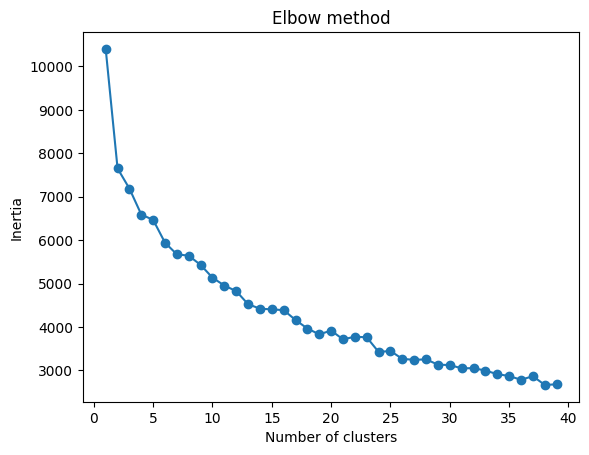

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

print(data.shape)
inertias = []
for i in range(1,40):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

import matplotlib.pyplot as plt

plt.plot(range(1,40), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [3]:
from sklearn.cluster import KMeans

print(data.shape)
n = 10
kmeans = KMeans(n_clusters=n)
kmeans.fit(data)
clusters = kmeans.predict(data)
print(clusters)

cluster_dict = {"cluster": clusters}
cluster_df = pl.from_dict(cluster_dict)

df = df.hstack(cluster_df)
print(df)


(204, 51)
[5 6 6 6 2 9 9 7 5 9 3 1 3 2 1 4 9 6 5 1 4 2 6 2 4 3 2 1 3 4 8 4 4 4 1 5 4
 4 3 5 4 6 2 4 3 2 9 5 2 1 1 1 7 3 9 9 5 3 9 3 4 4 9 2 4 4 1 4 0 6 9 4 1 3
 5 6 5 3 2 9 3 8 4 3 9 1 4 6 2 5 3 4 9 1 5 3 6 4 2 9 4 3 6 1 6 2 4 4 3 2 4
 8 4 8 9 5 9 9 2 8 6 8 8 2 4 7 6 4 9 1 9 3 4 5 3 4 9 9 9 9 2 2 2 3 9 1 9 1
 9 3 5 4 4 1 3 9 4 5 7 4 4 1 4 6 3 6 4 2 6 9 5 1 3 9 9 9 9 3 5 1 8 5 3 6 1
 1 3 3 9 3 7 3 4 2 3 4 3 2 2 1 2 4 1 4]
shape: (204, 52)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬─────────┐
│ column_0  ┆ column_1  ┆ column_2  ┆ column_3  ┆ … ┆ column_48 ┆ column_49 ┆ column_50 ┆ cluster │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---     │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ i32     │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═════════╡
│ -0.26118  ┆ -0.92435  ┆ 0.53281   ┆ 0.801414  ┆ … ┆ -0.5

In [4]:
named_cluster = name_df.hstack(cluster_df.select(pl.col("cluster")))
named_cluster = named_cluster.select(
    pl.col("name"),
    pl.col("cluster"),
).sort(
    pl.col("cluster")
)

print(named_cluster)
named_cluster.write_csv(f"./k-means-{n}n.csv")

shape: (204, 2)
┌──────────────────────────┬─────────┐
│ name                     ┆ cluster │
│ ---                      ┆ ---     │
│ str                      ┆ i32     │
╞══════════════════════════╪═════════╡
│ dance_data_101_corrected ┆ 0       │
│ dance_data_199_corrected ┆ 1       │
│ dance_data_107_corrected ┆ 1       │
│ dance_data_197_corrected ┆ 1       │
│ dance_data_83_corrected  ┆ 1       │
│ …                        ┆ …       │
│ dance_data_159_corrected ┆ 9       │
│ dance_data_200_corrected ┆ 9       │
│ dance_data_147_corrected ┆ 9       │
│ dance_data_158_corrected ┆ 9       │
│ dance_data_73_corrected  ┆ 9       │
└──────────────────────────┴─────────┘
